# Basic Reinforcement Learning

This example shows how a Lunar Lander can be trained to learn how to land between the flags on the ever-changing moon surface.  This example is a more "verbose" example, as you can see the classes for Neural Net predictors and for RL Support that I have created.  These classes have been generalized into other applications, including my Raspberry Pi Rover.

**Updates**: Have figured out a more robust way to install gym.  Previous approach stopped working (actually during a class!) after a CoLab update.

**Author**: W. Tod Newman
##Learning Objectives

   *  Learn the concepts behind reinforcement learning
   *  Understand how the Deep Q-Learning works at the highest level
   *  See the demo on how well a trained model will work (show the art of the possible!)


## Needed Libraries

These are libraries that will allow this code to run.  They are not installed in CoLaboratory by default so we need to load them.  They will load even through a firewall.

Sit back and relax.  This will take a while.

In [ ]:
%%time
!pip install np_utils
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip -q install -Iv pyglet==1.5.0
!pip install gym box2d box2d-kengz
!pip install statistics
!pip -q install pyopengl
!pip -q install pyvirtualdisplay
!apt-get install python-opengl -y
!sudo apt-get update --fix-missing && apt-get -qqq install xvfb -y > /dev/null
#!apt install xvfb -y
!apt install ffmpeg

     |████████████████████████████████| 61 kB 4.0 MB/s 
  Created wheel for np-utils: filename=np_utils-0.5.12.1-py3-none-any.whl size=57131 sha256=93c1863553310561a7a883101de7f3c053caec22b427223e4e0c2e05a33462e7
  Stored in directory: /root/.cache/pip/wheels/8c/4e/ef/095c24693723c329f4cdc1079861cdbb2487d4b41b2496a4e7
Successfully built np-utils
Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
libopenmpi-dev is already the newest version (2.1.1-8).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0

## GenNet - Tod's RL Generic Neural Net class

This class is very useful and generalizes across a number of RL applications.  It works for other Atari games as well as my Raspberry Pi-based autonomous rover.  This support two neural nets, one fully connected network with two hidden layers that uses the ADAM optimizer and one Convolutional Neural network that has 2 hidden convolutional layers and one hidden fully connected layer (plus code commented out to add a third convolutional layer if desired).  The CNN uses the RMSProp Optimizer.

In [ ]:
import numpy as np
import np_utils
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, Dropout, LeakyReLU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
K.image_data_format()
from tensorflow.keras.models import Sequential, Model, load_model
import csv

import tensorflow as tf
tf.test.gpu_device_name()

print(tf.__version__)


class GenNet(object):

    def __init__(self, **kwargs):
        self.verbose = kwargs.get('verbose', False)
        self.nodes_1 = kwargs.get('nodes_1', 50)
        self.nodes_2 = kwargs.get('nodes_2', 50)
        self.nodes_3 = kwargs.get('nodes_3', 50)
        self.num_actions = kwargs.get('num_actions', 4)
        self.num_inputs = kwargs.get('num_inputs', 8)

        self.load_weights = kwargs.get('load_weights', False)
        self.save_weights = kwargs.get('save_weights', False)

        self.log_file = kwargs.get('log_file')
        self.weights_file = kwargs.get('weights_file', None)
        #self.model_out = kwargs.get('model_file', None)
        self.obs_shape = kwargs.get('obs_shape')
        self.loss_log = []
        self.learning_rate = .0005

        self.model = self.nn()
        #self.model = self.cnn()

        if self.verbose:
            print(
                """
                    Creating neural net with options:
                    Nodes, layer 1: %d
                    Nodes, layer 2: %d
                    Load weights?: %s
                    Save weights?: %s
                    Weights file: %s
                    Log file: %s
                """
                % (self.nodes_1,
                   self.nodes_2,
                   str(self.load_weights),
                   str(self.save_weights),
                   self.weights_file,
                   #self.model_out,
                   self.log_file)
            )
            
    #
    #  This is a TF function we create to return a direct inference of the model.
    #  We do this because it's much faster when executed in a loop.
    #
    @tf.function
    def serve(self, x):
        return self.model(x, training=False)

    def cnn(self):
        input_shape = (1,84,110)
        model = Sequential()
        model.add(Conv2D(16, 8, strides=(4, 4),
                              padding='valid',
                              activation='relu',
                              input_shape=input_shape,
                              data_format='channels_first'
                              ))

        # Second convolutional layer
        model.add(Conv2D(32, 4, strides=(2, 2),
                              padding='valid',
                              activation='relu',
                              input_shape=input_shape,
                              data_format='channels_first'
                              ))
        '''
        # Third convolutional layer shown for reference (I don't use it...)
        model.add(Conv2D(60, 3, strides=(1, 1),
                              padding='valid',
                              activation='relu',
                              input_shape=input_shape,
                              data_format='channels_first'
                              ))
        '''
        # Flatten the convolution output
        model.add(Flatten())

        # First dense layer
        model.add(Dense(256, activation='relu'))
        
        # Output layer
        model.add(Dense(self.num_actions))
        
        # Optimizer - We'll pick Nadam because it works consistently and uses Momentum
        optimizer = optimizers.Nadam(lr=self.learning_rate)

        # Compile the model and assign loss function and metrics functions as well 
        # as optimizer.
        model.compile(loss='mean_squared_error',
                           optimizer=optimizer,
                           metrics=['accuracy'])

        # Load weights if desired                   
        if self.load_weights and self.weights_file is not None:
            if self.verbose:
                print("Loading model from %s" % self.weights_file)
            model.load_weights(self.weights_file)

        return model
        
        
    def nn(self):
        model = Sequential()

        # First layer.
        model.add(Dense(
            self.nodes_1, 
            input_shape=(self.num_inputs,)
        ))
        model.add(LeakyReLU(alpha=0.005))
        # If I could figure it out, we could use a training switch 
        # to turn dropout on when training and off when predicting.

        #model.add(Dropout(0.2))

        # Second layer.
        model.add(Dense(self.nodes_2))
        model.add(LeakyReLU(alpha=0.005))
        #model.add(Dropout(0.2))
        
        # Third layer.
        model.add(Dense(self.nodes_3))
        model.add(LeakyReLU(alpha=0.005))

        # Output layer.
        model.add(Dense(self.num_actions))
        model.add(Activation('linear'))

        # Compile the model and assign loss function and metrics functions as well 
        # as optimizer.
        optimizer = optimizers.Nadam(lr=self.learning_rate)
        model.compile(loss="mse", optimizer=optimizer, metrics=['accuracy'])
        
        # Load weights if desired        
        if self.load_weights and self.weights_file is not None:
            if self.verbose:
                print("Loading model from %s" % self.weights_file)
            model.load_weights(self.weights_file)

        return model

    def predict(self, state):
        try:
            #return self.model.predict(state.reshape(1, self.num_inputs)) # Slowest method as of TF2.0
            #return self.model.predict_on_batch(state.reshape(1, self.num_inputs)) # 10x faster than Predict          
            return self.serve(state.reshape(1, self.num_inputs)) # This is 100x faster than Predict
            
        except:
            raise Exception("PredictionError")

    def train(self, X, y, batch_size):
        history = LossHistory()
        sv_mod = callbacks.ModelCheckpoint(self.weights_file, 
                                           monitor='accuracy', 
                                           save_best_only=True, 
                                           save_freq="epoch")
        self.model.fit(
            X, y, batch_size=batch_size,
            epochs=1, verbose=0, callbacks=[history, sv_mod]
        )
        self.loss_log.append(history.losses)

    def log_results(self):
        # Save the results to a file so we can graph it later.
        with open(self.log_file, 'w') as lf:
            wr = csv.writer(lf)
            for loss_item in self.loss_log:
                wr.writerow(loss_item)
        self.loss_log = []

    def save_weights_file(self):
        if self.weights_file is not None:
            self.model.save_weights(self.weights_file, overwrite=True)


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

2.6.0


## GenRL- Tod's Generic RL support Library

This class allows us to do basic RL stuff.  It does the interfacing with both the Environment simulation (OpenAI's GYM environment) as well as with the Neural Net action predictor.  It also handles data management and training.

In [ ]:
import numpy as np
import random
import keras.backend as K


class Gen_RL(object):

    def __init__(self, model, **kwargs):

        self.verbose = kwargs.get('verbose', False)
        self.num_actions = kwargs.get('num_actions')

        self.epsilon = kwargs.get('epsilon', 1)
        self.min_epsilon = kwargs.get('min_epsilon', 0.05)
        self.batch_size = kwargs.get('batch_size')
        self.episodes = kwargs.get('episodes')
        self.frames = kwargs.get('frames', 0)
        self.replay_size = kwargs.get('replay_size')
        self.save_steps = kwargs.get('save_steps', 5000)
        self.gamma = kwargs.get('gamma', 0.95)
        self.num_inputs = kwargs.get('num_inputs')

        self.enable_training = kwargs.get('enable_training', True)

        self.replay = []
        self.steps = 0

        self.model = model
        self.counter = 0
        
        #
        # If we send along frames, that replaces episodes as the number of
        # steps we're going to take. So we need to reduce epsilon by frame
        # in this case, not by "terminal" or episode.
        #
        if self.frames != 0:
            self.has_terminal = False
            self.epsilon_divider = self.frames
        else:
            self.has_terminal = True
            self.epsilon_divider = self.episodes

        if self.verbose:
            print(
                """
                    Creating learner with options:
                    Starting epsilon: %d
                    Minimum epsilon: %f
                    Batch size: %d
                    Episodes: %d
                    Frames: %d
                    Replay (buffer) size: %d
                    Gamma: %f
                    Actions: %d
                    State inputs: %d
                """
                % (self.epsilon,
                   self.min_epsilon,
                   self.batch_size,
                   self.episodes,
                   self.frames,
                   self.replay_size,
                   self.gamma,
                   self.num_actions,
                   self.num_inputs)
            )

    def determine_action(self, state):
        '''
        Here we decide if we should Guess an action (and then learn from the results
        of the guess) or if we should predict a value based upon our model.
        '''
      
        #
        # Choose an action.  If our random number is lower than the current
        # epsilon we will 'guess' an action.
        #
        if random.random() < self.epsilon and self.enable_training is True:
            action = np.random.randint(0, self.num_actions)  # random
        else:
          
            #
            # We randomly landed in 'predict' mode, so we need to get Q values 
            # for each action.  We take the highest ranked action and return.
            #
            qval = self.model.predict(state)
            action = (np.argmax(qval))

        return action

    def step(self, state, action, reward, new_state, terminal):
        '''
        Conduct one RL step, train if we have enough data and increment epsilon.
        '''
       
        #
        # Store our Experience replay values each step.
        #
        self.replay.append((state, action, reward, new_state))
        
        #
        # If we've stored enough in our replay buffer, pop off the oldest.
        #
        if len(self.replay) > self.replay_size:
            self.replay.pop(0)
            
        #
        # If we have enough data to make a minibatch, go forth and train.
        #
        if len(self.replay) > self.batch_size:
          
            #
            # Randomly sample a batch (batch_size) of our experience replay memory
            #
            minibatch = random.sample(self.replay, self.batch_size)
            
            #
            # Process this minibatch to get a new set of training values.
            #
            X_train, y_train = self.process_minibatch(minibatch, terminal)
            
            #
            # Train the model on X,y from this minibatch.  This training is
            # cumulative, as we load the weights first.
            #
            self.model.train(X_train, y_train, self.batch_size)
            
        #
        # Decrement epsilon over time. This will determine how often we 'guess'
        # vs. how often we 'predict'
        #
        if self.epsilon > self.min_epsilon:
            if (self.has_terminal and terminal) or self.has_terminal is False:
                self.epsilon -= (1.0 / (self.epsilon_divider))
        
                self.epsilon = max (0.05, self.epsilon)
          
        #   
        # Save weights to our model.  NOT USED DUE TO MODELCHECKPOINT callback
        #
        #if self.model.save_weights and self.model.weights_file is not None:
        #    if self.steps % self.save_steps == 0 and self.steps > 0:
        #        print("Saving weights.")
        #        self.model.save_weights_file()

        self.steps += 1
        

    def process_minibatch(self, minibatch, terminal=False):
        ''' 
        Basic Q-Learning math.  We use our model to predict the current and previous
        Q-values for each record in our replay memory batch.
        Eventually returns the X and y training arrays.
        '''
      
        X_train = []
        y_train = []
        
        #
        # Loop through our batch and create arrays for X and y
        # so that we can fit our model at every step.
        #
        for memory in minibatch:
          
            #
            # Get stored values for each record in the minibatch.
            #
            old_state_m, action_m, reward_m, new_state_m = memory
            
            #
            # Use trained model to get action prediction on old state.
            #
            old_qval = self.model.predict(old_state_m)
            
            #
            # Get action prediction on new state.
            #
            newQ = self.model.predict(new_state_m)
            
            #
            # Estimate the optimal FUTURE value using Numpy's max.
            #
            maxQ = np.max(newQ)
            
            #
            # Define our label - The previous set of actions
            #
            y = np.zeros((1, self.num_actions))
            y[:] = old_qval[:]
            
            #
            # Check for terminal state (Signifies Episode is complete).
            #
            if not terminal: # Episode is not complete
                #
                # Here's where we perform a simple value iteration update, 
                # using the weighted average of the old action value and the new information
                # multiplied by our discount rate (gamma).
                #
                update = (reward_m + (self.gamma * maxQ))
                
            else:  # Episode is complete.  No use in applying the future parameters.
                update = reward_m
                
            #
            # Assign the new Q-value to y for the action we took.
            #
            y[0][action_m] = update
            
            #
            # Build training dataset by appending our previous state space
            # and our new y labels for previous and future actions.
            #
            X_train.append(old_state_m.reshape(self.num_inputs,))
            y_train.append(y.reshape(self.num_actions,))

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        return X_train, y_train


## Pick the Weights File for "Show" Mode

Right now I have the trained lunarlander file saved in my downloads directory

In [ ]:
!wget -O /content/lunarlander-mod 'https://raw.githubusercontent.com/todnewman/models/master/lunarlander_50_50_50.hdf5'
%cd /content
%ls -al

--2021-10-28 20:26:06--  https://raw.githubusercontent.com/todnewman/models/master/lunarlander_50_50_50.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112208 (110K) [application/octet-stream]
Saving to: ‘/content/lunarlander-mod’

/content/lunarlande 100%[===================>] 109.58K  --.-KB/s    in 0.01s   

2021-10-28 20:26:07 (8.13 MB/s) - ‘/content/lunarlander-mod’ saved [112208/112208]

/content
total 128
drwxr-xr-x 1 root root   4096 Oct 28 20:26 ./
drwxr-xr-x 1 root root   4096 Oct 28 19:08 ../
drwxr-xr-x 4 root root   4096 Oct 26 13:33 .config/
-rw-r--r-- 1 root root 112208 Oct 28 20:26 lunarlander-mod
drwxr-xr-x 1 root root   4096 Oct 26 13:34 sample_data/


## Main Function

This section will set up the Neural Net to predict what actions the Lunar Lander should take.  It also governs the initialization of the environment simulation and allows the Lunar Lander to receive environmental state values from the environment simulation and then receive rewards based on the appropriateness of the action.

This will train to be able to perform this activity after about 5,000 episodes.

To Train the Lander, uncomment the line "train_or_show = train" and ensure that "show" is commented out.  Once a trained model has been saved, switch to "show" mode to load the model into the empty lunar lander and start it predicting actions.

files.upload()

action space: Discrete(4)
observation space: Box(-inf, inf, (8,), float32)
Loading model from lunarlander-mod

                    Creating neural net with options:
                    Nodes, layer 1: 50
                    Nodes, layer 2: 50
                    Load weights?: True
                    Save weights?: False
                    Weights file: lunarlander-mod
                    Log file: loss_log.txt
                

                    Creating learner with options:
                    Starting epsilon: 1
                    Minimum epsilon: 0.050000
                    Batch size: 32
                    Episodes: 40
                    Frames: 0
                    Replay (buffer) size: 10000
                    Gamma: 0.950000
                    Actions: 4
                    State inputs: 8
                


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Landed! Score: 167
Landed! Score: 158
Landed! Score: 141
Crashed! Score: -77
Landed! Score: 132
Landed! Score: 118
Landed! Score: 139
Landed! Score: 95
Landed! Score: 139
Landed! Score: 132
Landed! Score: 143
RAM usage: 2.6136207580566406 GB
--------------------------------------------------------------------------------
Epsilon: 1.00000
Episode: 10
Mean: 112.43	Max: 158	Stdev: 68.65
Time for 10 Episodes: 5.694735050201416
Landed! Score: 151
Crashed! Score: -32
Landed! Score: 129
Landed! Score: 142
Landed! Score: 125
Landed! Score: 176
Landed! Score: 136
Landed! Score: 129
Landed! Score: 150
Landed! Score: 139
RAM usage: 3.681110382080078 GB
--------------------------------------------------------------------------------
Epsilon: 1.00000
Episode: 20
Mean: 124.76	Max: 176	Stdev: 57.18
Time for 10 Episodes: 4.896261692047119
Crashed! Score: -70
Landed! Score: 154
Landed! Score: 136
Landed! Score: 155
Landed! Score: 141
Landed! Score: 145
Landed! Score: 146
Landed! Score: 148
Landed! Scor

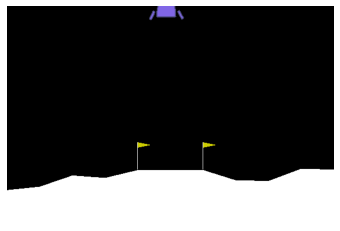

In [ ]:
"""
Implements Gen_RL in attempt to solve Gym's Lunar Lander environment.
This is the main function that calls the classes in later workbook blocks.
Better to execute this block last...
"""

import gym
import pandas as pd
import matplotlib.animation as animation
from statistics import mean, stdev
import matplotlib.pyplot as plt
from IPython.display import HTML
from google.colab import files
from pyvirtualdisplay import Display
from tensorflow.keras import callbacks
import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import psutil
%matplotlib inline

#
# Set up the display here to work inside CoLaboratory.  This will enable the
# videos at the end. When we're training large data sets, should probably comment
# this out because it uses lots of memory!
#
display = Display(visible=0, size=(1400, 900))
display.start()
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1


import time

frames = []

#
# Change the number of episodes.  About 5K episodes are needed to train the 
# model effectively.
#
episodes =  40

#
# The below won't change for LunarLander
#
inputs = 8
actions = 4

#
# Just change these to switch from training mode to inference (show) mode.
# When in 'show' mode you need to make sure you have a weights file uploaded
# (see previous block)
#

#train_or_show = 'train'            # TRAINING the agent
train_or_show = 'show'            # LOAD Trained Model in an Empty Agent


log_file = 'loss_log.txt'

#
# Define parameters for training vs. inference
#
if train_or_show == 'train':
    weights_file = 'lunarlander-train'
    enable_training = True
    load_weights = False
    save_weights = True
else:
    weights_file = 'lunarlander-mod'
    enable_training = False
    load_weights = True
    save_weights = False
#
# Create the environment. You can change this to other Gym environments
# to experiment.  Here we'll print out the action and observation spaces.
#
env = gym.make('LunarLander-v2')
print("action space: {0!r}".format(env.action_space))
print("observation space: {0!r}".format(env.observation_space))

obs_shape = env.observation_space.shape

#
# Set up the network by creating an instance of the GenNet class.
#
network = GenNet(nodes_1=50, nodes_2=50, nodes_3=50, num_actions=actions, 
                   num_inputs=inputs, verbose=True,
                   load_weights=load_weights, weights_file=weights_file, 
                   obs_shape=obs_shape, save_weights=save_weights, 
                   log_file=log_file)
                  
                 
#
# Setup Gen RL's deep RL model by creating an instance of the Gen_RL class.
#
rl = Gen_RL(network, episodes=episodes, num_actions=actions,
                  batch_size=32, min_epsilon=0.05, num_inputs=inputs,
                  replay_size=10000, gamma=0.95, verbose=True,
                  enable_training=enable_training)

def show_RAM_usage():
    py = psutil.Process(os.getpid())
    print('RAM usage: {} GB'.format(py.memory_info()[0]/2. ** 30))

rewards = []
results = []
max_steps = 600
repeat_action = 3


# Run.
for i in range(episodes):
    K.clear_session() # for the TF2.0 Memory Leak?
    start = time.time()

    # Get initial state.
    state = env.reset()

    terminal = False
    e_rewards = 0
    steps = 0

    while not terminal:
        steps += 1
        
        #
        # Send the state to Gen_RL, get our predicted action.
        #
        action = rl.determine_action(state)
        #
        # Best results come from performing the same action multiple times.  This
        # comes from the original DeepMind DQN paper.  This improves training time
        # but doesn't really sacrifice performance.  
        # Each time, the environment (OpenAI Gym) gives us the new state, a reward,
        # and whether the Episode is terminal or not.
        #
        for x in range(repeat_action):
            new_state, reward, terminal, _ = env.step(action)   
        #
        # Create an array of frames from the environment's 'render' feature.
        # This is primarily done in CoLaboratory due to the difficulty of
        # rendering to a display.  Outside of CoLab I'd just call env.render().
        # We switch this out when training large datasets because it will use all your
        # memory.
        #
        if train_or_show == 'show' or (train_or_show == 'train' and episodes < 60):
            frames.append(env.render(mode = 'rgb_array'))
        #
        # Add the info to our experience replay for training.  Experience Replay
        # is the breakthrough where data acquired during the online learning
        # process are stored and presented repeatedly to the underlying
        # RL algorithm. This increases data efficiency, while exploiting
        # the computational efficiency of the underlying algorithm.  There is a
        # lot of research into ER these days to improve it and mitigate its liabilities.
        # - https://arxiv.org/abs/1712.01275
        # - http://www.busoniu.net/files/papers/smcc11.pdf
        #
        if enable_training:
            rl.step(state, action, reward, new_state, terminal)   
        #
        # Accumulate rewards.
        #
        e_rewards += reward
        
        #
        # If the Episode is complete.
        #
        if terminal:
            
            #
            # The Episode is complete.  If we aren't training, be more verbose 
            # about the mission.
            #
            if not enable_training:
                if reward == -100:
                    result = 'Crashed'
                else:
                    result = 'Landed'
                print("%s! Score: %d" % (result, e_rewards))

            # Create Rewards Array.
            rewards.append(e_rewards)
            if len(rewards) > 10:
                rewards.pop(0)
            e_rewards = 0
            
        #
        # Update state for the next iteration in this episode. Our next action
        # will be based off of this state.
        #
        state = new_state
        
        #
        # This keeps us from getting stuck.
        #
        if steps > max_steps:
            print("Too many steps.")
            break
        #end = time.time()
        #print(end - start)
    #
    # Every 10th episode, print out parametrics.  This will help us determine
    # how well the training is progressing.
    #
    if i % 10 == 0 and i > 0:
        end = time.time()
        show_RAM_usage()
        print("-"*80)
        print("Epsilon: %.5f" % rl.epsilon)
        print("Episode: %d" % i)
        print("Mean: %.2f\tMax: %d\tStdev: %.2f" %
              (mean(rewards), max(rewards), stdev(rewards)))
        print(f"Time for 10 Episodes: {(end-start)*10}")
        results.append(mean(rewards))

# Just print out all of our mean rewards so we can plot them or
# do other fun things.

#plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)


if train_or_show == 'show':
    patch = plt.imshow(frames[0])
    plt.axis('off')
    animate = lambda i: patch.set_data(frames[i])
    ani = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
else:
    patch = plt.imshow(frames[0])
    animate = lambda i: patch.set_data(frames[i])
    network.log_results()
    df3 = pd.read_csv(log_file, header=0)
    df3.columns = ['Loss']
    df3.plot(y='Loss')
    for r in results:
        print(r)

env.close()


## Create JSHTML video

Rendering Javascript HTML so you can see the performance of the lander.  Be patient, this takes just over a minute.

In [ ]:
%time HTML(ani.to_jshtml())

This cell output is too large and can only be displayed while logged in.


## Create HTML5 (MP4) video
Here we can create a MP4 movie that can be sent as an attachment, etc.

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
CPU times: user 1min 39s, sys: 1.49 s, total: 1min 41s
Wall time: 1min 41s


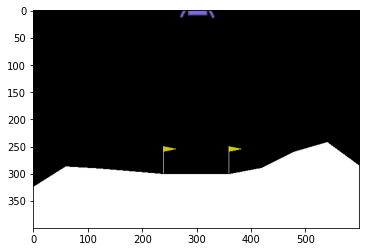

In [ ]:
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!apt install ffmpeg


patch = plt.imshow(frames[0])
animate = lambda i: patch.set_data(frames[i])        
ani = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
%time HTML(ani.to_html5_video())

## Save Video to Downloads folder

In [ ]:

!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null


Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='TodN'), bitrate=1800)
ani.save('working_inference.mp4', writer=writer)
files.download('working_inference.mp4')  # from colab to browser download


## Google Drive authentication Stuff

I don't like this much, but right now this is how I can allow the RL Models to be saved to the Google Drive.

In [ ]:
print(piglet.__version__)



In [ ]:
#!cp /content/lunarlander drive/.
%cd lunarlander/


In [ ]:
%cd /content
%ls -l

In [ ]:
from google.colab import files
files.download('loss_log.txt')

In [ ]:
%cd lunarlander/
%ls

In [ ]:
files.download('lunarlander.hdf5')